In [1]:
from cellrank.datasets import bone_marrow
import matplotlib.pyplot as plt
import project

In [2]:
adata = bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

In [3]:
adata.shape

(5780, 27876)

## Velocity estimation using scvelo

In [4]:
project.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

project.pp.pca(adata)
project.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
project.pp.moments(adata, n_pcs=None, n_neighbors=None)

In [5]:
# import scanpy as sc
# import scvelo as scv
# sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
# scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

In [6]:
project.tl.recover_dynamics(adata, n_jobs=-1)
project.tl.velocity(adata, mode="dynamical")
project.tl.latent_time(adata)

recovering dynamics (using 32/32 cores)


  0%|          | 0/613 [00:00<?, ?gene/s]

    finished (0:01:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


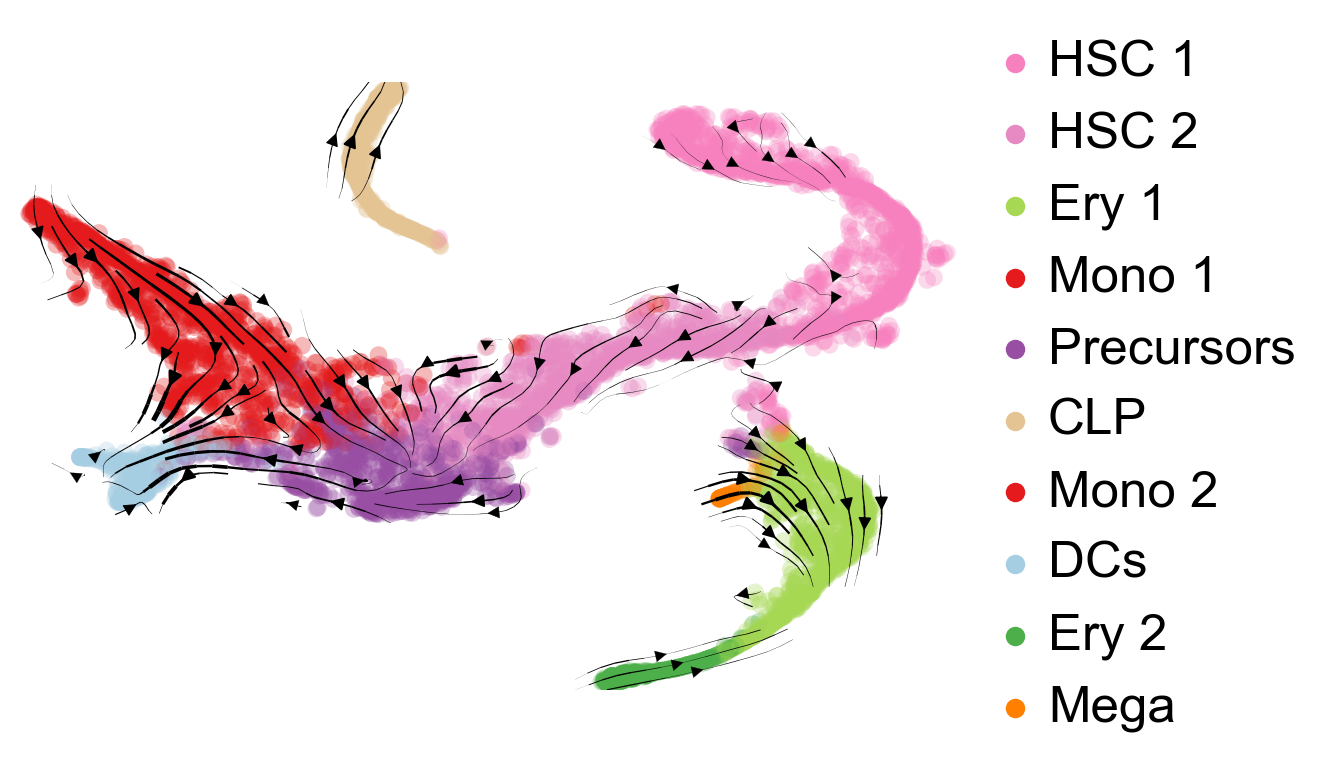

In [7]:
fig_kwargs = {"color": ["clusters"], "legend_loc": "right", "dpi": 100, "title": ""}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/velocities_umap_streamlines.png'
project.tl.velocity_graph(adata)
project.pl.velocity_embedding_stream(adata, **fig_kwargs)

check velocity genes with top likelihood in dynamical model.

In [8]:
# genes = ["ANGPT1", "RBPMS"]
genes = adata.var["fit_likelihood"].sort_values(ascending=False)[:2].index.to_list()

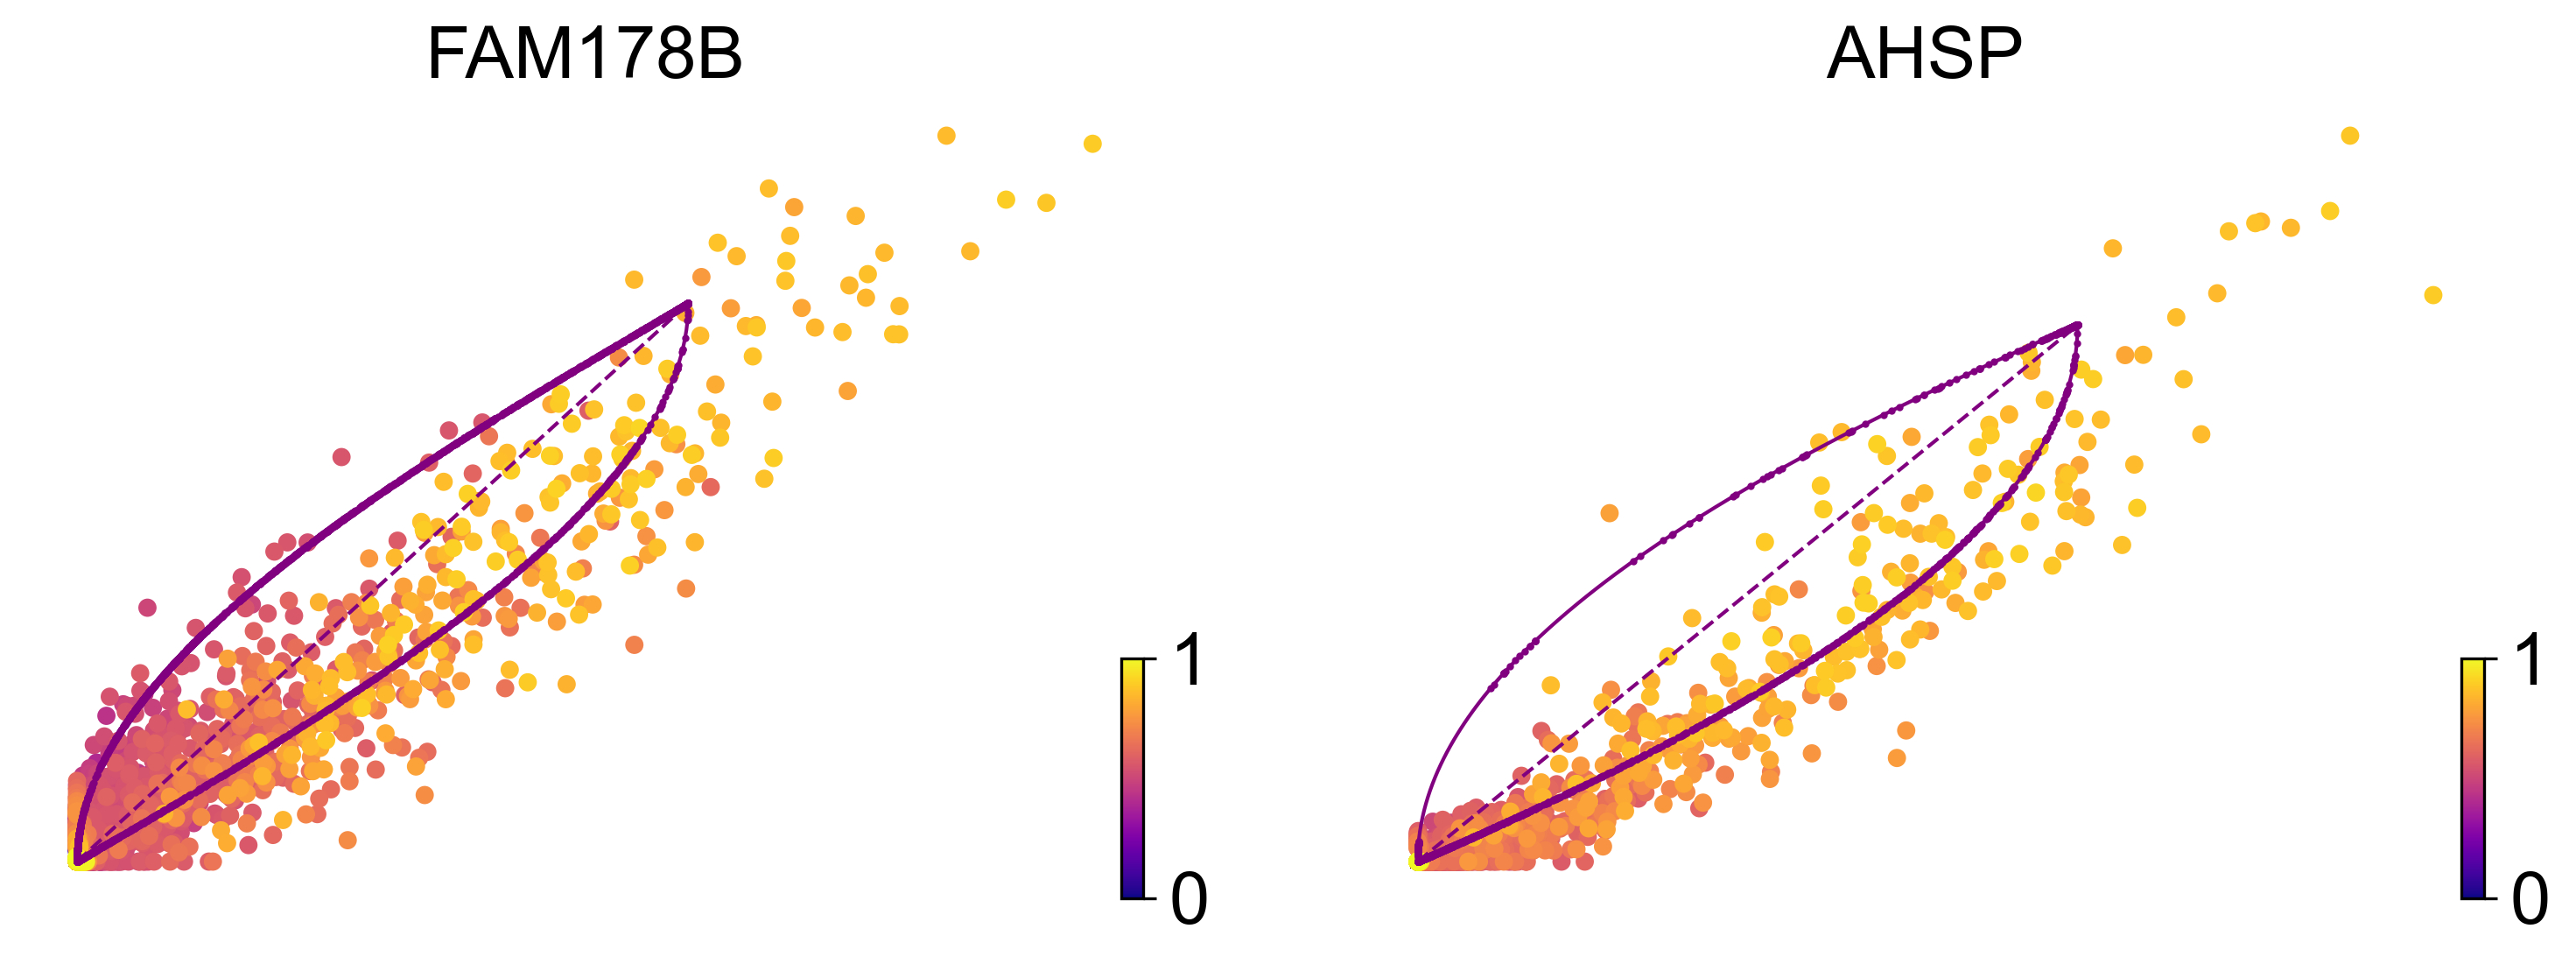

In [9]:
fig_kwargs = {
    "basis": genes,
    "color": "palantir_pseudotime",
    "color_map": "plasma",
    "frameon": False,
    "s": 100,
    "dpi": 150,
}
project.pl.scatter(adata, **fig_kwargs)

high degration: ANGPT1, NPR3, MSI2
transcription burst: CALR, KLF1, AHSP, NPR3

## Run GraphVelo

In [10]:
indices, _ = project.gv.adj_to_knn(adata.obsp["connectivities"])
adata.uns["neighbors"]["indices"] = indices

In [ ]:
project.gv.mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

67it [00:47,  1.36it/s]

In [ ]:
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = project.pl.gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

In [ ]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = project.pl.gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

In [ ]:
import seaborn as sns
gv = project.gv.GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [ ]:
adata.layers["velocity_gvs"] = gv.project_velocity(adata.layers["Ms"])
adata.layers["velocity_gvu"] = gv.project_velocity(adata.layers["Mu"])
adata.obsm["gv_pca"] = gv.project_velocity(adata.obsm["X_pca"])
adata.obsm["gv_tsne"] = gv.project_velocity(adata.obsm["X_tsne"])

In [ ]:
fig_kwargs = {
    "color": ["clusters"],
    "X": adata.obsm["X_tsne"],
    "V": adata.obsm["gv_tsne"],
    "legend_loc": "right",
    "dpi": 300,
    "title": "",
    "legend_fontsize": 12,
    "figsize": (4, 4),
}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/gv_result.png'
project.pl.velocity_embedding_stream(adata, **fig_kwargs)

In [ ]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity_gvs",
    "vu_layer": "velocity_gvu",
    "pointsize": 10,
    "ncols": 1,
    "scale": 3,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = project.pl.plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_gv100_phase.pdf', dpi=300, transparent=True)
plt.show()

In [ ]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity",
    "vu_layer": "velocity_u",
    "pointsize": 10,
    "ncols": 1,
    "scale": 1,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = project.pl.plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_hspc/genes_phase_velo.pdf', dpi=300, transparent=True)
plt.show()